# Spam Classification

In [1]:
import nltk 
import pandas as pd
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import sklearn.feature_extraction.text as text

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

import re
import nltk

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

In [2]:
df = pd.read_csv('spam.csv',encoding='cp1252')
df.shape

(5572, 5)

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
print(df['Unnamed: 2'].describe())
print(df['Unnamed: 3'].describe())
print(df['Unnamed: 4'].describe())

count                                                    50
unique                                                   43
top        bt not his girlfrnd... G o o d n i g h t . . .@"
freq                                                      3
Name: Unnamed: 2, dtype: object
count                        12
unique                       10
top        MK17 92H. 450Ppw 16"
freq                          2
Name: Unnamed: 3, dtype: object
count           6
unique          5
top       GNT:-)"
freq            2
Name: Unnamed: 4, dtype: object


In [5]:
df=df[['v1','v2']]

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Text Preprocessing

In [7]:
#lowercase
df['v2'] = df['v2'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(df['v2'].head())

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
Name: v2, dtype: object


In [8]:
#Punctuation removal
df['v2'] = df['v2'].str.replace('[^\w\s]','')
print(df['v2'].head())

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: v2, dtype: object


In [9]:
#Stopwords removal
stop = stopwords.words('english')
df['v2'] = df['v2'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
print(df['v2'].head())

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
Name: v2, dtype: object


In [10]:
#Stemming
st = PorterStemmer()
df['v2'] = df['v2'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
print(df['v2'].head())

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri 2 wkli comp win fa cup final tkt 21...
3                  u dun say earli hor u c alreadi say
4            nah dont think goe usf live around though
Name: v2, dtype: object


In [11]:
#Lamatization
from nltk.stem import WordNetLemmatizer
df['v2'] = df['v2'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(df['v2'].head())

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri 2 wkli comp win fa cup final tkt 21...
3                  u dun say earli hor u c alreadi say
4            nah dont think goe usf live around though
Name: v2, dtype: object


# Feature Engineering

In [12]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [13]:
# splitting into training and testing data
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['v2'], df['v1'])

In [14]:
train_y.value_counts()

ham     3612
spam     567
Name: v1, dtype: int64

In [15]:
test_y.value_counts()

ham     1213
spam     180
Name: v1, dtype: int64

In [16]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [17]:
train_y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [18]:
#Generating features using tfidf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['v2'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

# Building Model

In [19]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, test_y)

In [20]:
# Naive Bayes
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xtest_tfidf)
print ("Accuracy: ", accuracy)

Accuracy:  0.9655419956927495


In [21]:
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xtest_tfidf)
print ("Accuracy: ", accuracy)

Accuracy:  0.9511844938980617


In [22]:
#Build Model
model=naive_bayes.MultinomialNB()
nb=model.fit(xtrain_tfidf, train_y)
nb

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
predictions = nb.predict(xtest_tfidf)
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Results

In [24]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(test_y, predictions,target_names=["Ham", "Spam"]))

             precision    recall  f1-score   support

        Ham       0.96      1.00      0.98      1213
       Spam       1.00      0.73      0.85       180

avg / total       0.97      0.97      0.96      1393



In [25]:
#AUC score

from sklearn.metrics import roc_auc_score
nb_auc = roc_auc_score(test_y, nb.predict_proba(xtest_tfidf)[:, 1])
print("AUC for Naive Bayes Model: {:.3f}".format(nb_auc))

AUC for Naive Bayes Model: 0.984


# Generating Word Cloud for Spam words

In [26]:
df1=df.loc[df['v1'] == 'spam']
df1.shape

(747, 2)

In [27]:
df1.head()

,v1,v2
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
5,spam,freemsg hey darl 3 week word back id like fun ...
8,spam,winner valu network custom select receivea å90...
9,spam,mobil 11 month u r entitl updat latest colour ...
11,spam,six chanc win cash 100 20000 pound txt csh11 s...


In [28]:
stopwords = set(STOPWORDS) 
comment_words = ''
for val in df1['v2']: 
     # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split()             
    for words in tokens: 
        comment_words = comment_words + words + ' '

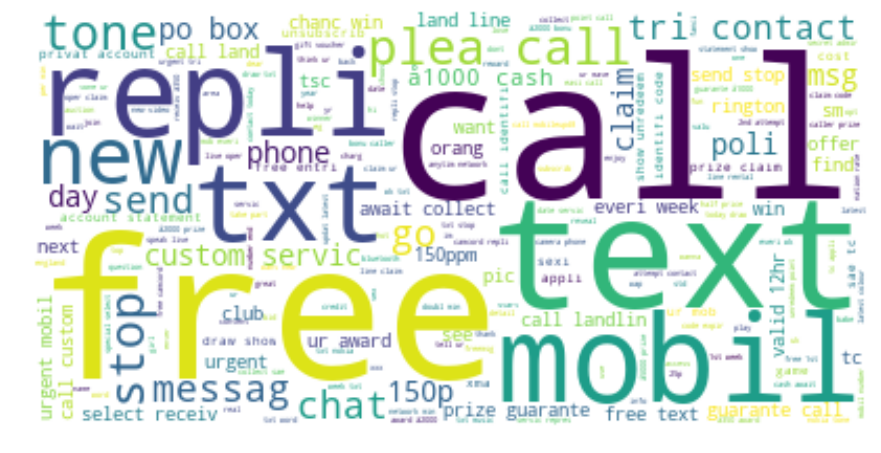

In [29]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(comment_words)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15, 15), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# The mails containing the above words would be most probably marked as spam